# Probability of Perfect Fairness

plotting only - calculations are in `metricCalculation.ipynb` file

probability of achieving perfect fairness (in different metrics), according to different metrics, for given group/imbalance ratio

- as function of group ratio
- as function of imbalance

## setup

In [1]:
import os
import warnings
from os import path

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import PercentFormatter

warnings.filterwarnings('ignore')
plt.style.use('default')

# SMALL_SIZE = 10
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 13
#
# plt.rc('font', size=SMALL_SIZE, family='Helvetica')          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
sample_size = 56        # 24
calculations_dir = path.join('out', 'calculations', f'n{sample_size}')
plots_dir = path.join('out', 'plots', f'n{sample_size}', 'perfect_fairness')
os.makedirs(plots_dir, exist_ok=True)

epsilons = [0,]
ratio_types = ['gr', 'ir']


dfs = {(ratio_type, epsilon): pd.read_csv(path.join(calculations_dir, f'perfect_fairness_{ratio_type}_eps{epsilon}.csv'))
       for ratio_type in ratio_types
       for epsilon in epsilons}

diff_metrics_styles = {
    'Accuracy equality difference': {'color': '#6699CC', 'marker': '*'},
    'Statistical parity difference': {'color': '#994455', 'marker': '.'},

    'Equal opportunity difference': {'color': '#004488', 'marker': 'v'},
    'Predictive equality difference': {'color': '#997700', 'marker': 'x'},

    'Negative predictive parity difference': {'color': '#EECC66', 'marker': '+'},
    'Positive predictive parity difference': {'color': '#EE99AA', 'marker': 'o'},
}

x_description = {
    'gr': 'Protected group ratio (GR)',
    'ir': 'Imbalance ratio (IR)',
}

In [3]:
def melt_df(df, base_metric):
    temp = df.pop(base_metric)
    length = len(df.columns)
    df = pd.melt(df)
    df[base_metric] = list(temp) * length
    return df

## plotting

In [28]:
def plot_mlp(df, base_metric, color_mapping, title='Proportion of perfect fairness', y_max=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    for col in color_mapping.keys():
        ax.plot(df[base_metric], df[col], label=col.replace('difference', ''), alpha=.5, **color_mapping[col])

    if y_max is not None:
        ax.set_ylim(0, y_max)

    ax.set_xlabel(x_description[base_metric])
    ax.set_ylabel('Probability of perfect fairness')
    ax.set_title(title)
    ax.spines[['top', 'right']].set_visible(False)
    # ax.yaxis.set_major_formatter(PercentFormatter(1))
    # ax.set_ylim(0, 0.85)
    ax.legend()
    plt.tight_layout()
    plt.show()
    return fig

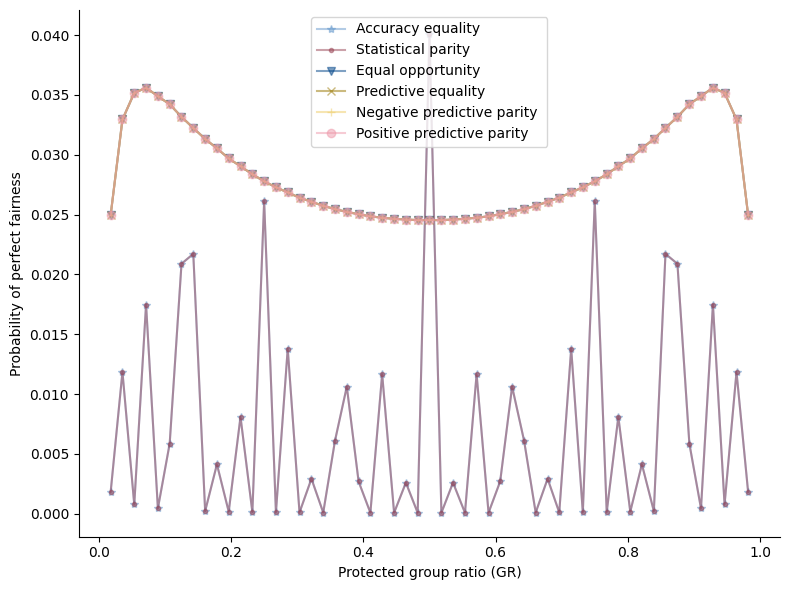

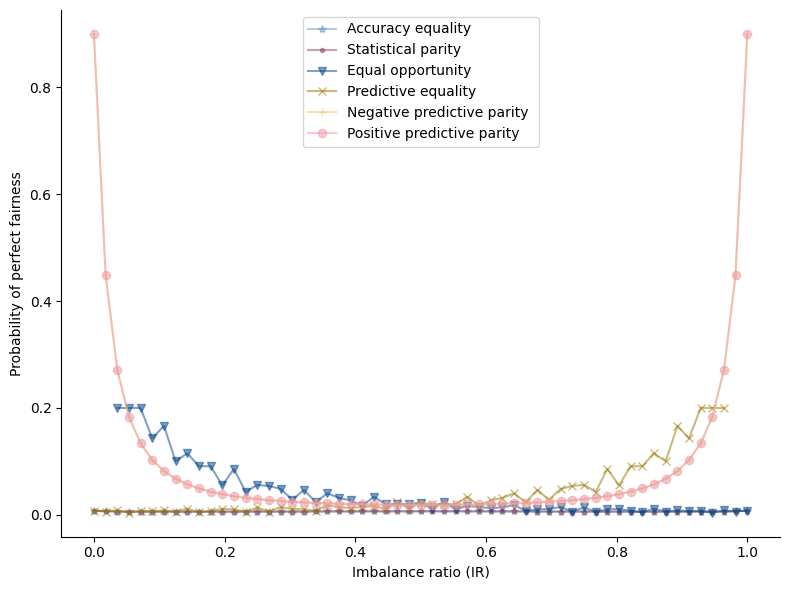

In [29]:
for ratio_type in ratio_types:
    for eps in epsilons:
        fig = plot_mlp(dfs[(ratio_type, eps)], ratio_type, diff_metrics_styles,
                       # title=f'Proportion of {"im" if eps != 0 else ""}perfect fairness in relation to {ratio_type.upper()}{f" (ε={eps})" if eps != 0 else ""}')
                       title='')
        fig.savefig(path.join(plots_dir, f'ppf_{ratio_type}_eps{eps}.svg'),
                    dpi=300)

## Close-ups for imbalance ratio

In [ ]:
base_metric = 'ir'
df = dfs[(base_metric, 0)]

fig, ax = plt.subplots(figsize=(8, 6))
for col in ['Statistical parity difference', 'Accuracy equality difference', 'Negative predictive parity difference']:
    ax.plot(df[base_metric], df[col], label=col,
            alpha=.3, **diff_metrics_styles[col])
ax.set_ylim(0, .06)
# ax.set_ylim(0, .01)
ax.set_xlabel(x_description[base_metric])
ax.set_ylabel('Probability')
ax.set_title('Proportion of perfect fairness')
ax.legend()
plt.show()

In [ ]:
base_metric = 'ir'
df = dfs[(base_metric, 0)]

fig, ax = plt.subplots(figsize=(8, 6))
for col in diff_metrics_styles.keys():
    if col == base_metric:
        continue
    ax.plot(df[base_metric], df[col], label=col, alpha=.6, **diff_metrics_styles[col])
ax.set_ylim(0, .6)
ax.set_xlabel(x_description[base_metric])
ax.set_ylabel('Probability')
ax.set_title('Proportion of perfect fairness')
ax.legend()
plt.show()

In [ ]:
ratio_type = 'ir'
selected_metrics = {

    'Accuracy equality difference': {'color': '#6699CC', 'marker': '*'},
    'Statistical parity difference': {'color': '#994455', 'marker': '.'},

    # 'Equal opportunity difference': {'color': '#004488', 'marker': 'v'},
    # 'Predictive equality difference': {'color': '#997700', 'marker': 'x'},

    'Negative predictive parity difference': {'color': '#EECC66', 'marker': '+'},
    'Positive predictive parity difference': {'color': '#EE99AA', 'marker': 'o'},
}

for eps in epsilons:
    for y_max in [.2, .06]:
        fig = plot_mlp(dfs[(ratio_type, eps)], ratio_type, selected_metrics,
                       # title=f'Proportion of {"im" if eps != 0 else ""}perfect fairness, ε={eps}',
                       title='',
                       y_max=y_max)
        fig.savefig(path.join(plots_dir, f'ppf_scaled_{ratio_type}_eps{eps}_y{y_max}.svg'),
                    dpi=300)

# eps=0 has some values so small that it benefits from another close-up
eps, y_max = 0, .015
del selected_metrics['Negative predictive parity difference']
del selected_metrics['Positive predictive parity difference']
fig = plot_mlp(dfs[(ratio_type, eps)], ratio_type, selected_metrics,
               # title=f'Proportion of {"im" if eps != 0 else ""}perfect fairness, ε={eps}',
               title='',
               y_max=y_max)
fig.savefig(path.join(plots_dir, f'ppf_scaled_{ratio_type}_eps{eps}_y{y_max}.svg'),
            dpi=300)

## Separate axes

In [ ]:
def separate_axis(df, base_metric, color_mapping, eps=0, percent=False):
    fig, ax = plt.subplots(3, 2, figsize=(12, 12), sharex=True)
    if eps == 0:
        fig.suptitle(f'Proportion of perfect fairness as a function of {base_metric.upper()}')
    else:
        fig.suptitle(f'Proportion of imperfect fairness as a function of {base_metric.upper()} (ε={eps})')

    for i, metric in enumerate(color_mapping.keys()):
        ax[i // 2, i % 2].plot(df[base_metric], df[metric], label=metric, **color_mapping[metric])
        # ax[i // 2, i % 2].set_xlabel(x_description[base_metric])
        ax[i // 2, i % 2].set_ylabel('Probability')
        ax[i // 2, i % 2].set_title(metric.replace('difference', ''))
        ax[i // 2, i % 2].set_ylim(0, ax[i // 2, i % 2].get_ylim()[1]*1.1)
        ax[i // 2, i % 2].spines[['top', 'right']].set_visible(False)
        if percent:
            ax[i // 2, i % 2].yaxis.set_major_formatter(PercentFormatter(1))
        # ax[i // 2, i % 2].legend()

    fig.tight_layout()
    plt.show()
    return fig

In [ ]:
for ratio_type in ratio_types:
    for eps in epsilons:
        fig = separate_axis(dfs[(ratio_type, eps)], ratio_type, diff_metrics_styles,
                            eps=eps, percent=True)
        fig.savefig(path.join(plots_dir, f'ppf_separated_{ratio_type}_percent_eps{eps}.svg'),
                    dpi=300)

# Ratio based metrics

not considered in the paper

In [ ]:
# dfs_ratio = {(ratio_type, eps): pd.read_csv(path.join(calculations_dir, f'ppf_{ratio_type}_ratios_eps{eps}.csv'))
#              for ratio_type in ratio_types
#              for eps in epsilons}
#
# ratio_metrics_styles = {    # { file: metric name }
#     'Accuracy equality ratio': {'color': 'green', 'marker': 'o'},
#     'Disparate impact': {'color': 'red', 'marker': '*'},
#     'Equal opportunity ratio': {'color': 'blue', 'marker': '.'},
#     'Predictive equality ratio': {'color': 'orange', 'marker': 's'},
#     'Positive predictive parity ratio': {'color': 'purple', 'marker': 'x'},
#     'Negative predictive parity ratio': {'color': 'brown', 'marker': '^'},
# }

In [ ]:
# for ratio_type in ratio_types:
#     for eps in epsilons:
#         fig = plot_mlp(dfs_ratio[(ratio_type, eps)].copy(), ratio_type, ratio_metrics_styles,
#                        title=f'Proportion of {"perfect" if eps == 0 else "imperfect"} fairness (ε={eps})')
#         fig.savefig(path.join(plots_dir, f'ppf_ratio_basic_{ratio_type}_e{eps}.png'),
#                     dpi=300)

In [ ]:
# # separate axis - ratios
# for ratio_type in ratio_types:
#     for eps in epsilons:
#         fig = separate_axis(dfs_ratio[(ratio_type, eps)], ratio_type, ratio_metrics_styles, eps=eps)
#         fig.savefig(path.join(plots_dir, f'ppf_ratio_separated_{ratio_type}_eps{eps}.png'),
#                     dpi=300)

In [ ]:
# # close-ups for IR
# ratio_type = 'ir'
# selected_ratio_metrics = {
#     'Accuracy equality ratio': {'color': 'green', 'marker': 'o'},
#     'Disparate impact': {'color': 'red', 'marker': '*'},
#     'Equal opportunity ratio': {'color': 'blue', 'marker': '.'},
#     'Predictive equality ratio': {'color': 'orange', 'marker': 's'},
#     # 'Positive predictive parity ratio': {'color': 'purple', 'marker': 'x'},
#     # 'Negative predictive parity ratio': {'color': 'brown', 'marker': '^'},
# }
# remove = [
#     [],
#     ['Equal opportunity ratio', 'Predictive equality ratio'],
# ]
#
# for i, y_max in enumerate([.12, .045]):
#     for k in remove[i]:
#         del selected_ratio_metrics[k]
#
#     for eps in epsilons:
#         fig = plot_mlp(dfs_ratio[(ratio_type, eps)].copy(), ratio_type, selected_ratio_metrics,
#                        # title=f'Proportion of {"perfect" if eps == 0 else "imperfect"} fairness (ε={eps})',
#                        title=f'Proportion of perfect fairness' if eps == 0 else f'Proportion of imperfect fairness (ε={eps})',
#                        y_max=y_max)
#         fig.savefig(path.join(plots_dir, f'ppf_ratio_scaled_{ratio_type}_e{eps}_y{y_max}.png'),
#                     dpi=300)

# Probability of NaN

In [30]:
def nan_probability(df, base_metric, color_mapping, title='Probability of NaN', y_max=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    for col in color_mapping.keys():
        ax.plot(df[base_metric], df[col], label=col.replace('difference', ''), alpha=.5, **color_mapping[col])

    if y_max is not None:
        ax.set_ylim(0, y_max)

    ax.set_xlabel(x_description[base_metric])
    ax.set_ylabel('Probability of undefined metric value')
    # ax.set_title(title)
    ax.spines[['top', 'right']].set_visible(False)
    ax.yaxis.set_major_formatter(PercentFormatter(1))

    ax.legend()
    plt.show()
    return fig

In [31]:
nan_dfs = {ratio_type: pd.read_csv(path.join(calculations_dir, f'nans_{ratio_type}.csv'))
       for ratio_type in ratio_types}

In [ ]:
for ratio_type in ratio_types:
    fig = nan_probability(nan_dfs[ratio_type], ratio_type, diff_metrics_styles,
                          # title=f'Probability of NaN for given value of {ratio_type.upper()}')
                          title='')
    fig.savefig(path.join(plots_dir, f'nan_{ratio_type}_line.svg'), dpi=300)

In [ ]:
for ratio_type in ratio_types:
    fig = nan_probability(nan_dfs[ratio_type], ratio_type, diff_metrics_styles, title=f'Probability of NaN for given value of {ratio_type.upper()}', y_max=.02)
    fig.savefig(path.join(plots_dir, f'nan_{ratio_type}_zoom_line.svg'), dpi=300)